# Load Freely Moving Mice Motion Marker .npy file

(11201006,)
MEAN 1618.6718608764256
MAX 2239.990234375
MIN 1016.2353515625


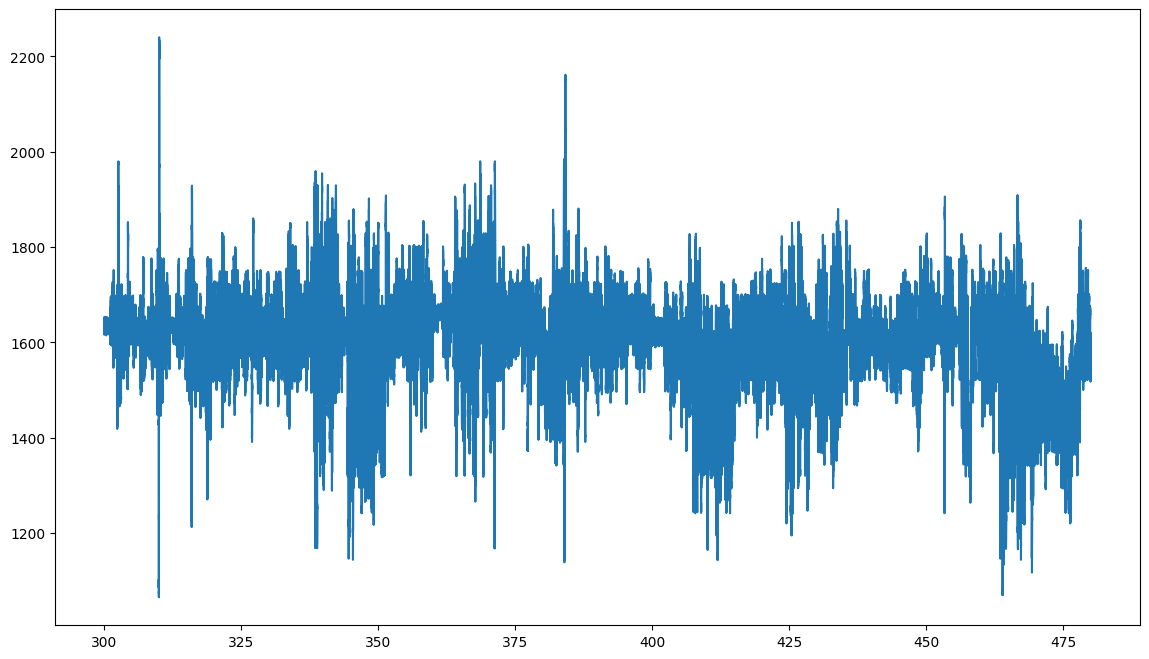

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd


path = '/data2/zhangyuhao/xinchao_data/Givenme/1670-2-tremor-Day5-bank_VN-FM_g0/Marker/'
raw_data = np.load(path + 'motion_marker.npy')
raw_data = raw_data[0]
raw_data = raw_data*5  # multiply a scaler, benefit to detection
print(raw_data.shape)
fs = 10593.2
mean = np.mean(raw_data)
print("MEAN", mean)
print("MAX", np.max(raw_data))
print("MIN", np.min(raw_data))
plt.figure(figsize=(14, 8))
start_show = 300
end_show = 480
time_axis = np.linspace(start_show, end_show, int(end_show*fs)-int(start_show*fs)) 
plt.plot(time_axis,raw_data[int(start_show*fs):int(end_show*fs)])  # 没动就是平的，动了才会变化，向上向下分别代表压力传感器的方向

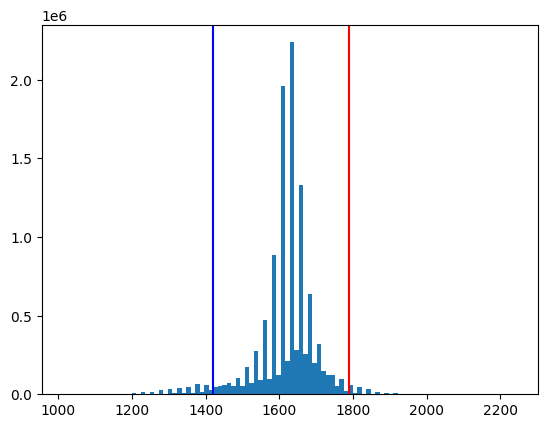

In [69]:
# 保证两阈值分别在3 sigma 处
high_thresh = 1790
low_thresh = 1420
plt.hist(raw_data, bins=100)
plt.axvline(low_thresh, color='b')
plt.axvline(high_thresh, color='r')
plt.savefig(path+f"force_distribution.png")
plt.show()

# Detect Static times

In [70]:
def find_transition_times(arr, sample_rate):
    if len(arr) == 0:
        return [], []
    
    initial_state = arr[0]
    arr_int = arr.astype(int)
    diff = np.diff(arr_int)
    
    # 找到上升沿和下降沿的索引
    up_indices = np.where(diff == 1)[0] + 1
    down_indices = np.where(diff == -1)[0] + 1

    # 转换为时间（秒）
    up_times = up_indices / sample_rate
    down_times = down_indices / sample_rate
    
    # 收集所有转换点并按时间排序
    transitions = []
    for t in up_times:
        transitions.append((t, 'up'))
    for t in down_times:
        transitions.append((t, 'down'))
    transitions.sort(key=lambda x: x[0])
    
    segments = []
    current_start = None
    
    # 处理初始状态
    if initial_state:
        current_start = 0.0
    
    # 处理每个转换点
    for t, typ in transitions:
        if typ == 'up':
            if current_start is None:
                current_start = t
        elif typ == 'down':
            if current_start is not None:
                duration = t - current_start
                if duration >= 10.0:  # 修改为10秒
                    segments.append((current_start, t))
                current_start = None
    
    # 处理末尾可能未闭合的段
    end_time = (len(arr) - 1) / sample_rate
    if current_start is not None:
        duration = end_time - current_start
        if duration >= 10.0:  # 修改为10秒
            segments.append((current_start, end_time))
    
    # 收集所有保留的转换点
    filtered_transitions = []
    for start, end in segments:
        filtered_transitions.append((start, 'up'))
        filtered_transitions.append((end, 'down'))
    
    # 按时间排序并分离上升和下降时间点
    filtered_transitions.sort(key=lambda x: x[0])
    up_edges = [t for t, typ in filtered_transitions if typ == 'up']
    down_edges = [t for t, typ in filtered_transitions if typ == 'down']
    return up_edges, down_edges

# 中值滤波去噪
filtered = signal.medfilt(raw_data, 5)
# 创建静止掩码（在高低阈值之间）
motion_mask = (filtered <= high_thresh) & (filtered >= low_thresh)  # 修改为检测静止状态
up, down = find_transition_times(motion_mask, fs)
print("上升沿时间点:", up)
print("下降沿时间点:", down)
all_edges = np.concatenate([up, down])
ordered_edges = np.sort(all_edges)
ordered_edges

上升沿时间点: [np.float64(11.043310803156741), np.float64(94.13491673904014), np.float64(281.328116149983), np.float64(391.4602764037307), np.float64(436.07125325680624), np.float64(607.2678699543103), np.float64(696.1920854888041), np.float64(744.5867160064947), np.float64(755.5152361892534), np.float64(796.1641430351546), np.float64(863.765056828909), np.float64(880.263848506589), np.float64(929.7467243137106), np.float64(967.9857833327039), np.float64(982.468470339463), np.float64(994.7608843408979), np.float64(1034.2197825019823)]
下降沿时间点: [np.float64(40.29320696295736), np.float64(106.35822980780122), np.float64(302.5420080806555), np.float64(403.3755616810784), np.float64(448.4979987161575), np.float64(626.8567571649737), np.float64(710.4014839708492), np.float64(755.4189480043801), np.float64(790.4022391722991), np.float64(863.754012007703), np.float64(880.2464788732394), np.float64(929.7341690896046), np.float64(958.7573160140466), np.float64(981.0063059321074), np.float64(994.7336026

array([  11.0433108 ,   40.29320696,   94.13491674,  106.35822981,
        281.32811615,  302.54200808,  391.4602764 ,  403.37556168,
        436.07125326,  448.49799872,  607.26786995,  626.85675716,
        696.19208549,  710.40148397,  744.58671601,  755.418948  ,
        755.51523619,  790.40223917,  796.16414304,  863.75401201,
        863.76505683,  880.24647887,  880.26384851,  929.73416909,
        929.74672431,  958.75731601,  967.98578333,  981.00630593,
        982.46847034,  994.73360269,  994.76088434, 1031.18047427,
       1034.2197825 , 1051.54013896])

# Plot detected duration

/tmp/ipykernel_2405450/2618550508.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_2405450/2618550508.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(path+f"Static_Detect_HighThr_{high_thresh}_LowThr_{low_thresh}.png")


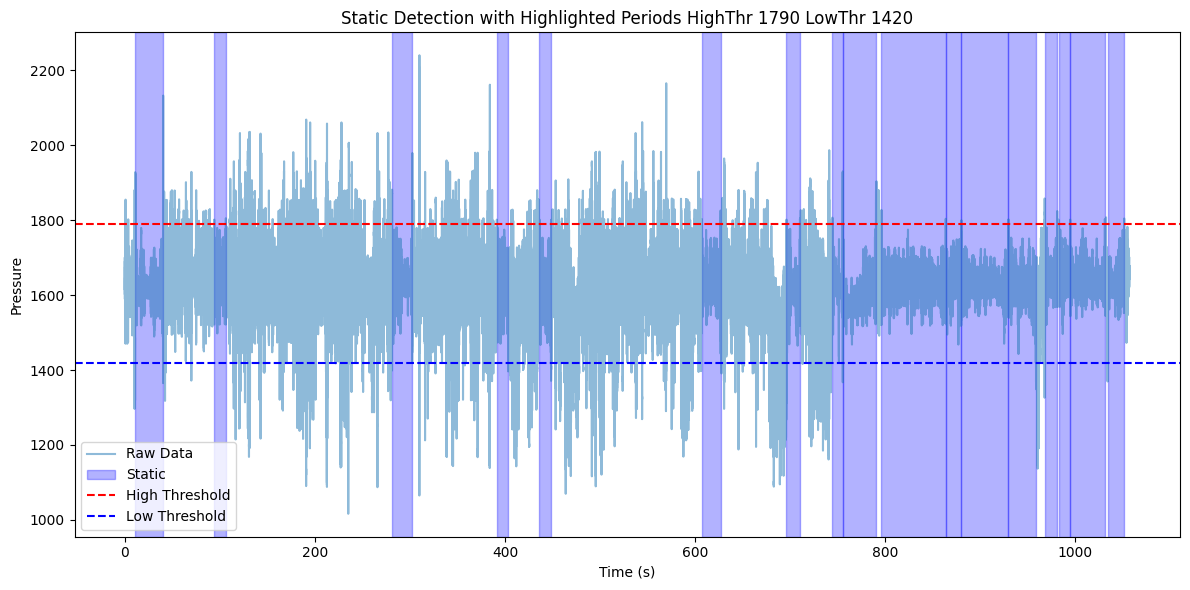

In [71]:
# 生成时间轴
times = np.arange(len(raw_data)) / fs
# 绘制结果
plt.figure(figsize=(12, 6))
plt.plot(times, raw_data, alpha=0.5, label='Raw Data')  # 原始数据

for i in range(0, len(ordered_edges), 2):
    start = ordered_edges[i]
    end = ordered_edges[i+1] if i+1 < len(ordered_edges) else times[-1]  # 处理奇数长度的情况
    # 只在第一次绘制时添加图例标签，后续不添加
    if i == 0:
        plt.axvspan(start, end, color='b', alpha=0.3, label='Static')
    else:
        plt.axvspan(start, end, color='b', alpha=0.3)

# 绘制阈值线
plt.axhline(high_thresh, color='r', linestyle='--', label='High Threshold')
plt.axhline(low_thresh, color='b', linestyle='--', label='Low Threshold')

# 处理图例去重
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Time (s)')
plt.ylabel('Pressure')
plt.title(f'Static Detection with Highlighted Periods HighThr {high_thresh} LowThr {low_thresh}')
plt.tight_layout()
plt.savefig(path+f"Static_Detect_HighThr_{high_thresh}_LowThr_{low_thresh}.png")
plt.show()

# Save to csv and npy

In [72]:
np.save(path + 'static_motion_segement.npy', ordered_edges)

init = 0  #如果最开始是静止的，这里为0，否则为1
init_inverse = 1  #如果最开始是静止的，这里为1，否则为0

# 生成CSV文件
initial_state = motion_mask[0]
end_time = (len(raw_data) - 1) / fs
times = [0.0] + ordered_edges.tolist()

# 确保添加结束时间
if not times or times[-1] < end_time:
    times.append(end_time)

# 生成间隔及状态标签
intervals = []
current_state = init if initial_state else init_inverse
for i in range(len(times) - 1):
    left = times[i]
    right = times[i + 1]
    if left >= right:
        continue  # 跳过无效间隔
    intervals.append((left, right, current_state))
    current_state = 1 - current_state  # 切换状态

# 保存为CSV
df = pd.DataFrame(intervals, columns=["time_interval_left_end", "time_interval_right_end", "run_or_stop"])
df.to_csv(path + "static_motion_segement.csv", index=False)